## Importing libraries and packages

In [2]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

## 1. Loading data :
Loading a single image, pose, and camera intrinsics from the Blender ficus dataset.
    

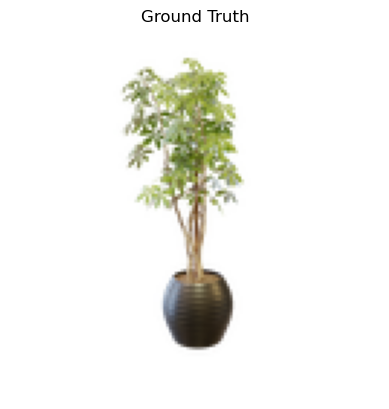

In [3]:

def load_blender_image(dataset_dir, img_size=(128, 128)): 
    with open(os.path.join(dataset_dir, 'transforms_train.json'), 'r') as f:
        meta = json.load(f)
        
    frame = meta['frames'][0]  # Use the first training image
    img_path = os.path.join(dataset_dir, frame['file_path'] + '.png')
    
    image = Image.open(img_path).resize(img_size, Image.LANCZOS)
    image = np.array(image) / 255.0 # Normalize to [0, 1]
    
    # Blend alpha channel onto white background
    rgb = image[..., :3] * image[..., 3:] + (1 - image[..., 3:])
    
    pose = np.array(frame['transform_matrix'])
    focal = 0.5 * img_size[0] / np.tan(0.5 * meta['camera_angle_x'])
    return rgb, pose, focal

# Path to Blender ficus dataset
ficus_dir = './data/nerf_synthetic/ficus'
image, camera_to_world, focal_length = load_blender_image(ficus_dir, img_size=(128, 128))
height, width = image.shape[:2]

plt.imshow(image)
plt.title('Ground Truth')
plt.axis('off')
plt.show()


## 2. Ray Generation
This step connects the 2D image to the 3D world. For every pixel in the 128x128 image, it calculates a unique 3D ray. 
Each ray has an origin (the camera's 3D location) and a direction vector that points from the camera, through that pixel and out into the scene. That results in a set of 10,000 rays, one for each pixel

In [4]:
def generate_camera_rays(height, width, focal_length, camera_to_world):
    # Create a grid of pixel coordinates (i: x-axis, j: y-axis)
    i, j = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')

    # Compute ray directions in camera space
    x = (i - width / 2) / focal_length
    y = -(j - height / 2) / focal_length
    z = -np.ones_like(x)
    directions_camera = np.stack([x, y, z], axis=-1)  # Shape: (H, W, 3)

    # Transform ray directions to world space
    directions_world = directions_camera @ camera_to_world[:3, :3].T

    # All rays originate from the camera origin in world space
    origins_world = np.broadcast_to(camera_to_world[:3, 3], directions_world.shape)

    return origins_world, directions_world

ray_origins, ray_directions = generate_camera_rays(height, width, focal_length, camera_to_world)


## 3. Point Sampling Along Rays
The neural network needs 3D points to evaluate, not just rays. This function takes each of the 10,000 rays and samples 32 distinct 3D points (x, y, z) along its path. 
These points are spaced evenly between a near and a far boundary, defining the volume in space where the object is expected to be.


In [ ]:
def sample_points_along_rays(ray_origins, ray_directions, near, far, num_samples):
    z_vals = np.linspace(near, far, num_samples)  # Shape: (N,)

    # Compute 3D sample points along each ray
    # ray_origins: (H, W, 3)
    # ray_directions: (H, W, 3)
    # z_vals: (N,)
    # Resulting points shape: (H, W, N, 3)
    points = ray_origins[..., None, :] + ray_directions[..., None, :] * z_vals[None, None, :, None]

    return points, z_vals

num_samples_per_ray = 32
near_bound, far_bound = 2.0, 6.0
sampled_points, z_values = sample_points_along_rays(ray_origins, ray_directions, near_bound, far_bound, num_samples_per_ray)


## Neural Network Definition
This is the core of the NeRF: a simple neural network. Its job is to act as a "function of the scene." It takes a single 3D coordinate (x, y, z) as input and predicts two things at that specific point in space: its color (r, g, b) and its density (sigma). A high density means the point is opaque, while a low density means it's transparent.

In [ ]:

class NeRFNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 4)  # Output: (r, g, b, sigma)
        )
        
    def forward(self, x):
        return self.mlp(x)

# Instantiate the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyNeRFNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)